In [1]:
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm



In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:

class Generator(nn.Module):
    """Image generator
    
    Takes a noise vector as input and syntheses a single channel image accordingly
    """

    def __init__(self, input_dims, output_dims):
        """Init function
        
        Declare the network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of input noise vector
            output_dims {int} -- Dimension of the output vector (flatten image)
        """
        super(Generator, self).__init__()
        ###  TODO: Change the architecture and value as CW2 Guidance required
        self.fc0 = nn.Sequential(
            nn.Linear(input_dims, 128), 
            nn.LeakyReLU(0.2))
        
        # output hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(128, output_dims), 
            nn.Tanh())

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of noise vectors in shape (<batch_size>x<input_dims>)
        
        Returns:
            Tensor -- a batch of flatten image in shape (<batch_size>x<output_dims>)
        """
        ###  TODO: modify to be consistent with the network structure
        x = self.fc0(x)
        x = self.fc1(x)
        return x


class Discriminator(nn.Module):
    """Image discriminator
    
    Takes a image as input and predict if it is real from the dataset or fake synthesised by the generator
    """

    def __init__(self, input_dims, output_dims=1):
        """Init function
        
        Declare the discriminator network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of the flatten input images
        
        Keyword Arguments:
            output_dims {int} -- Predicted probability (default: {1})
        """
        super(Discriminator, self).__init__()

        ###  TODO: Change the architecture and value as CW2 Guidance required
        
        
        
        
        self.fc0 = nn.Sequential(
            nn.Linear(input_dims, 784),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(784, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of 2D image in shape (<batch_size>xHxW)
        
        Returns:
            Tensor -- predicted probabilities (<batch_size>)
        """
        ###  TODO: modify to be consistent with the network structure

        x = self.fc0(x)
        x = self.fc1(x)
        return x


def show_result(G_net, z_, num_epoch, show=False, save=False, path='result.png'):
    """Result visualisation
    
    Show and save the generated figures in the grid fashion
    
    Arguments:
        G_net {[nn.Module]} -- The generator instant
        z_ {[Tensor]} -- Input noise vectors
        num_epoch {[int]} -- Indicate how many epoch has the generator been trained
    
    Keyword Arguments:
        show {bool} -- If to display the images (default: {False})
        save {bool} -- If to store the images (default: {False})
        path {str} -- path to store the images (default: {'result.png'})
    """

    ###  TODO: complete the rest of part
    # hint: use plt.subplots to construct grid
    # hint: use plt.imshow and plt.savefig to display and store the images
    
    show_data_fake = G_net(z_)
    fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), show_data_fake):
        img = img.detach().cpu().numpy()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
            
    fig.savefig(path)

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    """Loss tracker
    
    Plot the losses of generator and discriminator independently to see the trend
    
    Arguments:
        hist {[dict]} -- Tracking variables
    
    Keyword Arguments:
        show {bool} -- If to display the figure (default: {False})
        save {bool} -- If to store the figure (default: {False})
        path {str} -- path to store the figure (default: {'Train_hist.png'})
    """
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


def create_noise(num, dim):
    """Noise constructor
    
    returns a tensor filled with random numbers from a standard normal distribution
    
    Arguments:
        num {int} -- Number of vectors
        dim {int} -- Dimension of vectors
    
    Returns:
        [Tensor] -- the generated noise vector batch
    """
    return torch.randn(num, dim)


In [7]:
if __name__ == '__main__':
    # initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_dir = './MNIST_data/'
    save_dir = './MNIST_GAN_results/'
    image_save_dir = './MNIST_GAN_results/results'

    # create folder if not exist
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    if not os.path.exists(image_save_dir):
        os.mkdir(image_save_dir)



In [18]:
    # training parameters
    batch_size = 100
    learning_rate = 0.0002
    epochs = 200

    # parameters for Models
    image_size = 28
    G_input_dim = 100
    G_output_dim = image_size * image_size
    D_input_dim = image_size * image_size
    D_output_dim = 1
    hidden_size = 32

In [19]:
    # construct the dataset and data loader
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,), std=(0.5,))])
    train_data = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 600/600 [00:14<00:00, 40.03it/s]


Epoch 1 of 200 with 14.99 s
Generator loss: 1.59068991, Discriminator loss: 0.44312468


100%|██████████| 600/600 [00:14<00:00, 40.10it/s]


Epoch 2 of 200 with 14.97 s
Generator loss: 2.15011326, Discriminator loss: 0.33596053


100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch 3 of 200 with 14.93 s
Generator loss: 2.21318821, Discriminator loss: 0.40660217


100%|██████████| 600/600 [00:14<00:00, 40.17it/s]


Epoch 4 of 200 with 14.94 s
Generator loss: 2.96394287, Discriminator loss: 0.22755875


100%|██████████| 600/600 [00:15<00:00, 39.56it/s]


Epoch 5 of 200 with 15.17 s
Generator loss: 2.78145654, Discriminator loss: 0.34232968


100%|██████████| 600/600 [00:15<00:00, 39.47it/s]


Epoch 6 of 200 with 15.20 s
Generator loss: 2.31295394, Discriminator loss: 0.47248519


100%|██████████| 600/600 [00:14<00:00, 40.06it/s]


Epoch 7 of 200 with 14.98 s
Generator loss: 2.33922460, Discriminator loss: 0.47547755


100%|██████████| 600/600 [00:15<00:00, 39.61it/s]


Epoch 8 of 200 with 15.15 s
Generator loss: 2.52527007, Discriminator loss: 0.44302266


100%|██████████| 600/600 [00:15<00:00, 39.54it/s]


Epoch 9 of 200 with 15.18 s
Generator loss: 2.57391955, Discriminator loss: 0.48574460


100%|██████████| 600/600 [00:15<00:00, 39.97it/s]


Epoch 10 of 200 with 15.01 s
Generator loss: 2.60814393, Discriminator loss: 0.49736665


100%|██████████| 600/600 [00:15<00:00, 39.30it/s]


Epoch 11 of 200 with 15.27 s
Generator loss: 2.72398226, Discriminator loss: 0.49449856


100%|██████████| 600/600 [00:15<00:00, 39.31it/s]


Epoch 12 of 200 with 15.27 s
Generator loss: 2.97428272, Discriminator loss: 0.46613248


100%|██████████| 600/600 [00:15<00:00, 39.70it/s]


Epoch 13 of 200 with 15.12 s
Generator loss: 3.27106594, Discriminator loss: 0.40378537


100%|██████████| 600/600 [00:15<00:00, 39.71it/s]


Epoch 14 of 200 with 15.11 s
Generator loss: 3.79929283, Discriminator loss: 0.30496584


100%|██████████| 600/600 [00:15<00:00, 39.32it/s]


Epoch 15 of 200 with 15.26 s
Generator loss: 4.25319135, Discriminator loss: 0.25410362


100%|██████████| 600/600 [00:15<00:00, 38.78it/s]


Epoch 16 of 200 with 15.48 s
Generator loss: 4.19554858, Discriminator loss: 0.25201526


100%|██████████| 600/600 [00:15<00:00, 39.72it/s]


Epoch 17 of 200 with 15.11 s
Generator loss: 3.90882702, Discriminator loss: 0.28228595


100%|██████████| 600/600 [00:15<00:00, 39.75it/s]


Epoch 18 of 200 with 15.10 s
Generator loss: 3.78818387, Discriminator loss: 0.31852676


100%|██████████| 600/600 [00:14<00:00, 40.54it/s]


Epoch 19 of 200 with 14.80 s
Generator loss: 3.40439848, Discriminator loss: 0.39979465


100%|██████████| 600/600 [00:14<00:00, 40.63it/s]


Epoch 20 of 200 with 14.77 s
Generator loss: 3.20020937, Discriminator loss: 0.44024105


100%|██████████| 600/600 [00:14<00:00, 40.79it/s]
<ipython-input-3-9ee013a202c8>:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize=(7,7), nrows=5, ncols=5, sharey=True, sharex=True)


Epoch 21 of 200 with 14.71 s
Generator loss: 3.27776811, Discriminator loss: 0.43344719


100%|██████████| 600/600 [00:14<00:00, 40.25it/s]


Epoch 22 of 200 with 14.91 s
Generator loss: 3.05013307, Discriminator loss: 0.47735250


100%|██████████| 600/600 [00:15<00:00, 39.94it/s]


Epoch 23 of 200 with 15.03 s
Generator loss: 3.03770373, Discriminator loss: 0.48542095


100%|██████████| 600/600 [00:14<00:00, 40.56it/s]


Epoch 24 of 200 with 14.80 s
Generator loss: 2.98047976, Discriminator loss: 0.52683840


100%|██████████| 600/600 [00:14<00:00, 40.27it/s]


Epoch 25 of 200 with 14.90 s
Generator loss: 2.92100223, Discriminator loss: 0.53630767


100%|██████████| 600/600 [00:14<00:00, 40.10it/s]


Epoch 26 of 200 with 14.96 s
Generator loss: 2.91997098, Discriminator loss: 0.54495872


100%|██████████| 600/600 [00:14<00:00, 40.14it/s]


Epoch 27 of 200 with 14.95 s
Generator loss: 2.85352533, Discriminator loss: 0.55762490


100%|██████████| 600/600 [00:14<00:00, 40.49it/s]


Epoch 28 of 200 with 14.82 s
Generator loss: 2.88413210, Discriminator loss: 0.56195044


100%|██████████| 600/600 [00:14<00:00, 40.10it/s]


Epoch 29 of 200 with 14.96 s
Generator loss: 2.83533887, Discriminator loss: 0.55127781


100%|██████████| 600/600 [00:14<00:00, 40.37it/s]


Epoch 30 of 200 with 14.86 s
Generator loss: 2.82661627, Discriminator loss: 0.55261474


100%|██████████| 600/600 [00:14<00:00, 40.68it/s]


Epoch 31 of 200 with 14.75 s
Generator loss: 2.84883657, Discriminator loss: 0.54797001


100%|██████████| 600/600 [00:14<00:00, 40.77it/s]


Epoch 32 of 200 with 14.72 s
Generator loss: 2.92214355, Discriminator loss: 0.54512695


100%|██████████| 600/600 [00:14<00:00, 40.67it/s]


Epoch 33 of 200 with 14.76 s
Generator loss: 3.05500961, Discriminator loss: 0.51614322


100%|██████████| 600/600 [00:14<00:00, 40.49it/s]


Epoch 34 of 200 with 14.82 s
Generator loss: 3.69497318, Discriminator loss: 0.39433322


100%|██████████| 600/600 [00:14<00:00, 40.64it/s]


Epoch 35 of 200 with 14.77 s
Generator loss: 4.64401396, Discriminator loss: 0.26372354


100%|██████████| 600/600 [00:14<00:00, 40.76it/s]


Epoch 36 of 200 with 14.72 s
Generator loss: 4.89564716, Discriminator loss: 0.22830789


100%|██████████| 600/600 [00:14<00:00, 40.94it/s]


Epoch 37 of 200 with 14.66 s
Generator loss: 4.23754095, Discriminator loss: 0.32560504


100%|██████████| 600/600 [00:14<00:00, 41.46it/s]


Epoch 38 of 200 with 14.48 s
Generator loss: 3.79895857, Discriminator loss: 0.38613603


100%|██████████| 600/600 [00:14<00:00, 41.46it/s]


Epoch 39 of 200 with 14.47 s
Generator loss: 3.35026854, Discriminator loss: 0.46451762


100%|██████████| 600/600 [00:14<00:00, 41.40it/s]


Epoch 40 of 200 with 14.49 s
Generator loss: 3.14364516, Discriminator loss: 0.50973638


100%|██████████| 600/600 [00:14<00:00, 41.65it/s]


Epoch 41 of 200 with 14.41 s
Generator loss: 3.06329420, Discriminator loss: 0.54747650


100%|██████████| 600/600 [00:14<00:00, 41.35it/s]


Epoch 42 of 200 with 14.51 s
Generator loss: 2.99875167, Discriminator loss: 0.55844016


100%|██████████| 600/600 [00:14<00:00, 41.40it/s]


Epoch 43 of 200 with 14.49 s
Generator loss: 2.91659207, Discriminator loss: 0.56826192


100%|██████████| 600/600 [00:14<00:00, 41.54it/s]


Epoch 44 of 200 with 14.44 s
Generator loss: 2.87210335, Discriminator loss: 0.58678855


100%|██████████| 600/600 [00:14<00:00, 41.38it/s]


Epoch 45 of 200 with 14.50 s
Generator loss: 2.83474924, Discriminator loss: 0.60080942


100%|██████████| 600/600 [00:14<00:00, 41.54it/s]


Epoch 46 of 200 with 14.45 s
Generator loss: 2.80856981, Discriminator loss: 0.61766155


100%|██████████| 600/600 [00:14<00:00, 41.30it/s]


Epoch 47 of 200 with 14.53 s
Generator loss: 2.77945560, Discriminator loss: 0.62373499


100%|██████████| 600/600 [00:14<00:00, 41.19it/s]


Epoch 48 of 200 with 14.57 s
Generator loss: 2.77574262, Discriminator loss: 0.62060072


100%|██████████| 600/600 [00:14<00:00, 41.16it/s]


Epoch 49 of 200 with 14.58 s
Generator loss: 2.76723932, Discriminator loss: 0.62742688


100%|██████████| 600/600 [00:14<00:00, 41.45it/s]


Epoch 50 of 200 with 14.48 s
Generator loss: 2.72378743, Discriminator loss: 0.65152459


100%|██████████| 600/600 [00:14<00:00, 41.65it/s]


Epoch 51 of 200 with 14.41 s
Generator loss: 2.62918260, Discriminator loss: 0.66650091


100%|██████████| 600/600 [00:14<00:00, 41.42it/s]


Epoch 52 of 200 with 14.49 s
Generator loss: 2.66284821, Discriminator loss: 0.64036575


100%|██████████| 600/600 [00:14<00:00, 41.18it/s]


Epoch 53 of 200 with 14.57 s
Generator loss: 2.79498787, Discriminator loss: 0.60528453


100%|██████████| 600/600 [00:14<00:00, 41.25it/s]


Epoch 54 of 200 with 14.55 s
Generator loss: 2.85195925, Discriminator loss: 0.58863830


100%|██████████| 600/600 [00:14<00:00, 41.37it/s]


Epoch 55 of 200 with 14.51 s
Generator loss: 2.86033224, Discriminator loss: 0.59603653


100%|██████████| 600/600 [00:14<00:00, 41.32it/s]


Epoch 56 of 200 with 14.52 s
Generator loss: 2.76918124, Discriminator loss: 0.61244927


100%|██████████| 600/600 [00:14<00:00, 41.03it/s]


Epoch 57 of 200 with 14.63 s
Generator loss: 2.70629773, Discriminator loss: 0.62127421


100%|██████████| 600/600 [00:14<00:00, 40.64it/s]


Epoch 58 of 200 with 14.76 s
Generator loss: 2.66445154, Discriminator loss: 0.62161580


100%|██████████| 600/600 [00:14<00:00, 41.10it/s]


Epoch 59 of 200 with 14.60 s
Generator loss: 2.60275834, Discriminator loss: 0.62945998


100%|██████████| 600/600 [00:14<00:00, 40.82it/s]


Epoch 60 of 200 with 14.70 s
Generator loss: 2.62287688, Discriminator loss: 0.63682917


100%|██████████| 600/600 [00:14<00:00, 40.38it/s]


Epoch 61 of 200 with 14.86 s
Generator loss: 2.58981817, Discriminator loss: 0.63077959


100%|██████████| 600/600 [00:14<00:00, 40.25it/s]


Epoch 62 of 200 with 14.91 s
Generator loss: 2.54844487, Discriminator loss: 0.65470463


100%|██████████| 600/600 [00:14<00:00, 40.17it/s]


Epoch 63 of 200 with 14.94 s
Generator loss: 2.53510102, Discriminator loss: 0.66671359


100%|██████████| 600/600 [00:14<00:00, 40.91it/s]


Epoch 64 of 200 with 14.67 s
Generator loss: 2.52309812, Discriminator loss: 0.66006011


100%|██████████| 600/600 [00:14<00:00, 40.84it/s]


Epoch 65 of 200 with 14.69 s
Generator loss: 2.55470128, Discriminator loss: 0.66370597


100%|██████████| 600/600 [00:14<00:00, 40.89it/s]


Epoch 66 of 200 with 14.68 s
Generator loss: 2.62990371, Discriminator loss: 0.62022011


100%|██████████| 600/600 [00:14<00:00, 40.96it/s]


Epoch 67 of 200 with 14.65 s
Generator loss: 2.70337042, Discriminator loss: 0.60689055


100%|██████████| 600/600 [00:14<00:00, 40.69it/s]


Epoch 68 of 200 with 14.75 s
Generator loss: 2.71646183, Discriminator loss: 0.60809772


100%|██████████| 600/600 [00:14<00:00, 40.98it/s]


Epoch 69 of 200 with 14.64 s
Generator loss: 2.62245086, Discriminator loss: 0.63189058


100%|██████████| 600/600 [00:14<00:00, 40.98it/s]


Epoch 70 of 200 with 14.64 s
Generator loss: 2.58355531, Discriminator loss: 0.64309617


100%|██████████| 600/600 [00:14<00:00, 41.13it/s]


Epoch 71 of 200 with 14.59 s
Generator loss: 2.53756471, Discriminator loss: 0.65833398


100%|██████████| 600/600 [00:14<00:00, 40.38it/s]


Epoch 72 of 200 with 14.86 s
Generator loss: 2.49557508, Discriminator loss: 0.66767672


100%|██████████| 600/600 [00:14<00:00, 40.70it/s]


Epoch 73 of 200 with 14.74 s
Generator loss: 2.51820938, Discriminator loss: 0.66140148


100%|██████████| 600/600 [00:14<00:00, 41.01it/s]


Epoch 74 of 200 with 14.63 s
Generator loss: 2.42712277, Discriminator loss: 0.68037482


100%|██████████| 600/600 [00:14<00:00, 41.08it/s]


Epoch 75 of 200 with 14.61 s
Generator loss: 2.42780842, Discriminator loss: 0.67778852


100%|██████████| 600/600 [00:14<00:00, 40.73it/s]


Epoch 76 of 200 with 14.73 s
Generator loss: 2.43087224, Discriminator loss: 0.68763221


100%|██████████| 600/600 [00:14<00:00, 41.08it/s]


Epoch 77 of 200 with 14.61 s
Generator loss: 2.41420104, Discriminator loss: 0.68406272


100%|██████████| 600/600 [00:14<00:00, 40.92it/s]


Epoch 78 of 200 with 14.67 s
Generator loss: 2.41361492, Discriminator loss: 0.68542735


100%|██████████| 600/600 [00:14<00:00, 40.97it/s]


Epoch 79 of 200 with 14.65 s
Generator loss: 2.41995427, Discriminator loss: 0.67636812


100%|██████████| 600/600 [00:15<00:00, 39.52it/s]


Epoch 80 of 200 with 15.18 s
Generator loss: 2.49474104, Discriminator loss: 0.65702666


100%|██████████| 600/600 [00:14<00:00, 40.99it/s]


Epoch 81 of 200 with 14.64 s
Generator loss: 2.54122748, Discriminator loss: 0.64584066


100%|██████████| 600/600 [00:14<00:00, 40.54it/s]


Epoch 82 of 200 with 14.80 s
Generator loss: 2.54510512, Discriminator loss: 0.65669582


100%|██████████| 600/600 [00:14<00:00, 40.64it/s]


Epoch 83 of 200 with 14.77 s
Generator loss: 2.54534859, Discriminator loss: 0.63667066


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch 84 of 200 with 14.88 s
Generator loss: 2.47342018, Discriminator loss: 0.66865353


100%|██████████| 600/600 [00:14<00:00, 40.42it/s]


Epoch 85 of 200 with 14.85 s
Generator loss: 2.40852956, Discriminator loss: 0.67818653


100%|██████████| 600/600 [00:14<00:00, 40.58it/s]


Epoch 86 of 200 with 14.79 s
Generator loss: 2.42425099, Discriminator loss: 0.67709998


100%|██████████| 600/600 [00:14<00:00, 40.14it/s]


Epoch 87 of 200 with 14.95 s
Generator loss: 2.38616895, Discriminator loss: 0.69160439


100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch 88 of 200 with 14.93 s
Generator loss: 2.37016693, Discriminator loss: 0.70152508


100%|██████████| 600/600 [00:14<00:00, 40.18it/s]


Epoch 89 of 200 with 14.93 s
Generator loss: 2.35022695, Discriminator loss: 0.69543748


100%|██████████| 600/600 [00:14<00:00, 40.42it/s]


Epoch 90 of 200 with 14.85 s
Generator loss: 2.38148135, Discriminator loss: 0.69884698


100%|██████████| 600/600 [00:14<00:00, 40.73it/s]


Epoch 91 of 200 with 14.73 s
Generator loss: 2.36504653, Discriminator loss: 0.69467777


100%|██████████| 600/600 [00:14<00:00, 40.71it/s]


Epoch 92 of 200 with 14.74 s
Generator loss: 2.35632970, Discriminator loss: 0.70093526


100%|██████████| 600/600 [00:14<00:00, 40.43it/s]


Epoch 93 of 200 with 14.84 s
Generator loss: 2.35583328, Discriminator loss: 0.69592235


100%|██████████| 600/600 [00:14<00:00, 40.09it/s]


Epoch 94 of 200 with 14.97 s
Generator loss: 2.33661235, Discriminator loss: 0.70053167


100%|██████████| 600/600 [00:14<00:00, 40.02it/s]


Epoch 95 of 200 with 14.99 s
Generator loss: 2.36652316, Discriminator loss: 0.69426726


100%|██████████| 600/600 [00:14<00:00, 40.14it/s]


Epoch 96 of 200 with 14.95 s
Generator loss: 2.32620276, Discriminator loss: 0.70503052


100%|██████████| 600/600 [00:15<00:00, 39.54it/s]


Epoch 97 of 200 with 15.18 s
Generator loss: 2.36909327, Discriminator loss: 0.68662559


100%|██████████| 600/600 [00:14<00:00, 40.01it/s]


Epoch 98 of 200 with 15.00 s
Generator loss: 2.34910845, Discriminator loss: 0.68645720


100%|██████████| 600/600 [00:14<00:00, 40.54it/s]


Epoch 99 of 200 with 14.80 s
Generator loss: 2.38447179, Discriminator loss: 0.68998332


100%|██████████| 600/600 [00:14<00:00, 40.53it/s]


Epoch 100 of 200 with 14.81 s
Generator loss: 2.37324893, Discriminator loss: 0.69193694


100%|██████████| 600/600 [00:15<00:00, 39.85it/s]


Epoch 101 of 200 with 15.06 s
Generator loss: 2.35031980, Discriminator loss: 0.68883576


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch 102 of 200 with 14.88 s
Generator loss: 2.36153177, Discriminator loss: 0.69705121


100%|██████████| 600/600 [00:14<00:00, 40.49it/s]


Epoch 103 of 200 with 14.82 s
Generator loss: 2.33766302, Discriminator loss: 0.70663550


100%|██████████| 600/600 [00:14<00:00, 40.50it/s]


Epoch 104 of 200 with 14.82 s
Generator loss: 2.36061144, Discriminator loss: 0.69993335


100%|██████████| 600/600 [00:14<00:00, 40.02it/s]


Epoch 105 of 200 with 14.99 s
Generator loss: 2.30717073, Discriminator loss: 0.71381379


100%|██████████| 600/600 [00:14<00:00, 40.32it/s]


Epoch 106 of 200 with 14.88 s
Generator loss: 2.31764938, Discriminator loss: 0.71779799


100%|██████████| 600/600 [00:14<00:00, 40.24it/s]


Epoch 107 of 200 with 14.91 s
Generator loss: 2.25893075, Discriminator loss: 0.71975013


100%|██████████| 600/600 [00:15<00:00, 39.78it/s]


Epoch 108 of 200 with 15.09 s
Generator loss: 2.25248592, Discriminator loss: 0.71773801


100%|██████████| 600/600 [00:14<00:00, 40.56it/s]


Epoch 109 of 200 with 14.79 s
Generator loss: 2.27546613, Discriminator loss: 0.71813561


100%|██████████| 600/600 [00:14<00:00, 40.37it/s]


Epoch 110 of 200 with 14.86 s
Generator loss: 2.25514611, Discriminator loss: 0.72997154


100%|██████████| 600/600 [00:14<00:00, 40.43it/s]


Epoch 111 of 200 with 14.84 s
Generator loss: 2.23871809, Discriminator loss: 0.72921339


100%|██████████| 600/600 [00:15<00:00, 39.51it/s]


Epoch 112 of 200 with 15.19 s
Generator loss: 2.23326750, Discriminator loss: 0.73272673


100%|██████████| 600/600 [00:14<00:00, 40.16it/s]


Epoch 113 of 200 with 14.94 s
Generator loss: 2.24302096, Discriminator loss: 0.73219644


100%|██████████| 600/600 [00:14<00:00, 40.48it/s]


Epoch 114 of 200 with 14.83 s
Generator loss: 2.21422445, Discriminator loss: 0.74643704


100%|██████████| 600/600 [00:15<00:00, 39.99it/s]


Epoch 115 of 200 with 15.01 s
Generator loss: 2.21088307, Discriminator loss: 0.73800403


100%|██████████| 600/600 [00:15<00:00, 39.82it/s]


Epoch 116 of 200 with 15.07 s
Generator loss: 2.23798673, Discriminator loss: 0.72058780


100%|██████████| 600/600 [00:15<00:00, 39.89it/s]


Epoch 117 of 200 with 15.04 s
Generator loss: 2.24713006, Discriminator loss: 0.73111072


100%|██████████| 600/600 [00:15<00:00, 39.96it/s]


Epoch 118 of 200 with 15.02 s
Generator loss: 2.24295598, Discriminator loss: 0.73111600


100%|██████████| 600/600 [00:15<00:00, 39.98it/s]


Epoch 119 of 200 with 15.01 s
Generator loss: 2.22961947, Discriminator loss: 0.72949295


100%|██████████| 600/600 [00:15<00:00, 39.83it/s]


Epoch 120 of 200 with 15.07 s
Generator loss: 2.20312301, Discriminator loss: 0.73364420


100%|██████████| 600/600 [00:14<00:00, 40.31it/s]


Epoch 121 of 200 with 14.89 s
Generator loss: 2.22387454, Discriminator loss: 0.73977929


100%|██████████| 600/600 [00:15<00:00, 39.61it/s]


Epoch 122 of 200 with 15.15 s
Generator loss: 2.18082870, Discriminator loss: 0.74340231


100%|██████████| 600/600 [00:15<00:00, 39.84it/s]


Epoch 123 of 200 with 15.06 s
Generator loss: 2.16589271, Discriminator loss: 0.74990960


100%|██████████| 600/600 [00:15<00:00, 39.82it/s]


Epoch 124 of 200 with 15.07 s
Generator loss: 2.18245932, Discriminator loss: 0.74430837


100%|██████████| 600/600 [00:14<00:00, 40.02it/s]


Epoch 125 of 200 with 14.99 s
Generator loss: 2.19937263, Discriminator loss: 0.74273723


100%|██████████| 600/600 [00:15<00:00, 39.96it/s]


Epoch 126 of 200 with 15.02 s
Generator loss: 2.17569379, Discriminator loss: 0.75511222


100%|██████████| 600/600 [00:15<00:00, 39.72it/s]


Epoch 127 of 200 with 15.11 s
Generator loss: 2.14831423, Discriminator loss: 0.75224942


100%|██████████| 600/600 [00:15<00:00, 39.33it/s]


Epoch 128 of 200 with 15.26 s
Generator loss: 2.15782264, Discriminator loss: 0.75805054


100%|██████████| 600/600 [00:15<00:00, 39.79it/s]


Epoch 129 of 200 with 15.08 s
Generator loss: 2.13707014, Discriminator loss: 0.75503921


100%|██████████| 600/600 [00:15<00:00, 39.74it/s]


Epoch 130 of 200 with 15.10 s
Generator loss: 2.14850836, Discriminator loss: 0.75142741


100%|██████████| 600/600 [00:15<00:00, 39.62it/s]


Epoch 131 of 200 with 15.14 s
Generator loss: 2.11501559, Discriminator loss: 0.75794571


100%|██████████| 600/600 [00:15<00:00, 39.38it/s]


Epoch 132 of 200 with 15.24 s
Generator loss: 2.13363939, Discriminator loss: 0.75630350


100%|██████████| 600/600 [00:15<00:00, 39.46it/s]


Epoch 133 of 200 with 15.21 s
Generator loss: 2.12709328, Discriminator loss: 0.75494212


100%|██████████| 600/600 [00:14<00:00, 40.14it/s]


Epoch 134 of 200 with 14.95 s
Generator loss: 2.13494895, Discriminator loss: 0.76062471


100%|██████████| 600/600 [00:15<00:00, 39.69it/s]


Epoch 135 of 200 with 15.12 s
Generator loss: 2.11414774, Discriminator loss: 0.75102594


100%|██████████| 600/600 [00:15<00:00, 38.91it/s]


Epoch 136 of 200 with 15.42 s
Generator loss: 2.12120484, Discriminator loss: 0.74761116


100%|██████████| 600/600 [00:15<00:00, 39.47it/s]


Epoch 137 of 200 with 15.20 s
Generator loss: 2.11975928, Discriminator loss: 0.75990208


100%|██████████| 600/600 [00:15<00:00, 39.68it/s]


Epoch 138 of 200 with 15.12 s
Generator loss: 2.10172029, Discriminator loss: 0.76688331


100%|██████████| 600/600 [00:15<00:00, 39.49it/s]


Epoch 139 of 200 with 15.20 s
Generator loss: 2.11522796, Discriminator loss: 0.76173725


100%|██████████| 600/600 [00:15<00:00, 39.12it/s]


Epoch 140 of 200 with 15.34 s
Generator loss: 2.10727276, Discriminator loss: 0.76455464


100%|██████████| 600/600 [00:15<00:00, 39.32it/s]


Epoch 141 of 200 with 15.27 s
Generator loss: 2.08786581, Discriminator loss: 0.76439733


100%|██████████| 600/600 [00:15<00:00, 39.41it/s]


Epoch 142 of 200 with 15.23 s
Generator loss: 2.09838675, Discriminator loss: 0.76588650


100%|██████████| 600/600 [00:15<00:00, 39.34it/s]


Epoch 143 of 200 with 15.25 s
Generator loss: 2.07741521, Discriminator loss: 0.76389381


100%|██████████| 600/600 [00:15<00:00, 39.33it/s]


Epoch 144 of 200 with 15.26 s
Generator loss: 2.09080624, Discriminator loss: 0.76892830


100%|██████████| 600/600 [00:15<00:00, 39.26it/s]


Epoch 145 of 200 with 15.28 s
Generator loss: 2.08641816, Discriminator loss: 0.76834194


100%|██████████| 600/600 [00:15<00:00, 39.13it/s]


Epoch 146 of 200 with 15.34 s
Generator loss: 2.08234298, Discriminator loss: 0.76834769


100%|██████████| 600/600 [00:15<00:00, 39.69it/s]


Epoch 147 of 200 with 15.12 s
Generator loss: 2.09342819, Discriminator loss: 0.76510793


100%|██████████| 600/600 [00:15<00:00, 39.16it/s]


Epoch 148 of 200 with 15.32 s
Generator loss: 2.07635356, Discriminator loss: 0.77522404


100%|██████████| 600/600 [00:15<00:00, 39.94it/s]


Epoch 149 of 200 with 15.02 s
Generator loss: 2.05685592, Discriminator loss: 0.77746981


100%|██████████| 600/600 [00:15<00:00, 39.80it/s]


Epoch 150 of 200 with 15.08 s
Generator loss: 2.07449462, Discriminator loss: 0.76614093


100%|██████████| 600/600 [00:15<00:00, 39.48it/s]


Epoch 151 of 200 with 15.20 s
Generator loss: 2.05425288, Discriminator loss: 0.76998614


100%|██████████| 600/600 [00:15<00:00, 39.79it/s]


Epoch 152 of 200 with 15.08 s
Generator loss: 2.06116947, Discriminator loss: 0.77343998


100%|██████████| 600/600 [00:14<00:00, 40.10it/s]


Epoch 153 of 200 with 14.97 s
Generator loss: 2.04478570, Discriminator loss: 0.77758350


100%|██████████| 600/600 [00:15<00:00, 39.75it/s]


Epoch 154 of 200 with 15.10 s
Generator loss: 2.05191948, Discriminator loss: 0.77030991


100%|██████████| 600/600 [00:15<00:00, 39.93it/s]


Epoch 155 of 200 with 15.03 s
Generator loss: 2.05955828, Discriminator loss: 0.77176396


100%|██████████| 600/600 [00:15<00:00, 39.68it/s]


Epoch 156 of 200 with 15.12 s
Generator loss: 2.04676032, Discriminator loss: 0.77008191


100%|██████████| 600/600 [00:15<00:00, 39.55it/s]


Epoch 157 of 200 with 15.17 s
Generator loss: 2.05015610, Discriminator loss: 0.77123217


100%|██████████| 600/600 [00:15<00:00, 39.90it/s]


Epoch 158 of 200 with 15.04 s
Generator loss: 2.06178840, Discriminator loss: 0.77574835


100%|██████████| 600/600 [00:15<00:00, 39.91it/s]


Epoch 159 of 200 with 15.04 s
Generator loss: 2.04973022, Discriminator loss: 0.76965611


100%|██████████| 600/600 [00:15<00:00, 39.90it/s]


Epoch 160 of 200 with 15.04 s
Generator loss: 2.02041280, Discriminator loss: 0.78447334


100%|██████████| 600/600 [00:15<00:00, 39.46it/s]


Epoch 161 of 200 with 15.21 s
Generator loss: 2.04693451, Discriminator loss: 0.77263939


100%|██████████| 600/600 [00:15<00:00, 39.70it/s]


Epoch 162 of 200 with 15.11 s
Generator loss: 2.04406457, Discriminator loss: 0.77087648


100%|██████████| 600/600 [00:15<00:00, 39.69it/s]


Epoch 163 of 200 with 15.12 s
Generator loss: 2.02899150, Discriminator loss: 0.77433449


100%|██████████| 600/600 [00:15<00:00, 39.67it/s]


Epoch 164 of 200 with 15.13 s
Generator loss: 2.03161756, Discriminator loss: 0.78083446


100%|██████████| 600/600 [00:15<00:00, 39.94it/s]


Epoch 165 of 200 with 15.02 s
Generator loss: 2.02604049, Discriminator loss: 0.77917103


100%|██████████| 600/600 [00:15<00:00, 38.43it/s]


Epoch 166 of 200 with 15.62 s
Generator loss: 2.01082261, Discriminator loss: 0.77649455


100%|██████████| 600/600 [00:15<00:00, 39.25it/s]


Epoch 167 of 200 with 15.29 s
Generator loss: 2.03788059, Discriminator loss: 0.77838610


100%|██████████| 600/600 [00:15<00:00, 38.82it/s]


Epoch 168 of 200 with 15.46 s
Generator loss: 2.01149297, Discriminator loss: 0.77930545


100%|██████████| 600/600 [00:15<00:00, 39.82it/s]


Epoch 169 of 200 with 15.07 s
Generator loss: 2.03251987, Discriminator loss: 0.77701432


100%|██████████| 600/600 [00:15<00:00, 39.64it/s]


Epoch 170 of 200 with 15.14 s
Generator loss: 2.02018759, Discriminator loss: 0.78709165


100%|██████████| 600/600 [00:15<00:00, 39.58it/s]


Epoch 171 of 200 with 15.16 s
Generator loss: 2.01857903, Discriminator loss: 0.77453730


100%|██████████| 600/600 [00:15<00:00, 39.96it/s]


Epoch 172 of 200 with 15.02 s
Generator loss: 2.00938059, Discriminator loss: 0.78196572


100%|██████████| 600/600 [00:15<00:00, 39.73it/s]


Epoch 173 of 200 with 15.11 s
Generator loss: 2.03628728, Discriminator loss: 0.77808216


100%|██████████| 600/600 [00:15<00:00, 39.25it/s]


Epoch 174 of 200 with 15.29 s
Generator loss: 2.01364939, Discriminator loss: 0.78799969


100%|██████████| 600/600 [00:15<00:00, 39.74it/s]


Epoch 175 of 200 with 15.10 s
Generator loss: 2.00685316, Discriminator loss: 0.77613766


100%|██████████| 600/600 [00:15<00:00, 39.42it/s]


Epoch 176 of 200 with 15.22 s
Generator loss: 2.01959130, Discriminator loss: 0.78306891


100%|██████████| 600/600 [00:15<00:00, 39.27it/s]


Epoch 177 of 200 with 15.28 s
Generator loss: 2.00062378, Discriminator loss: 0.77868797


100%|██████████| 600/600 [00:15<00:00, 39.83it/s]


Epoch 178 of 200 with 15.07 s
Generator loss: 2.00721709, Discriminator loss: 0.78828812


100%|██████████| 600/600 [00:15<00:00, 39.37it/s]


Epoch 179 of 200 with 15.24 s
Generator loss: 2.00314194, Discriminator loss: 0.78220294


100%|██████████| 600/600 [00:15<00:00, 39.49it/s]


Epoch 180 of 200 with 15.20 s
Generator loss: 1.99752866, Discriminator loss: 0.78434705


100%|██████████| 600/600 [00:15<00:00, 39.65it/s]


Epoch 181 of 200 with 15.13 s
Generator loss: 1.99492668, Discriminator loss: 0.77864983


100%|██████████| 600/600 [00:16<00:00, 36.51it/s]


Epoch 182 of 200 with 16.43 s
Generator loss: 2.01492630, Discriminator loss: 0.78560985


100%|██████████| 600/600 [00:15<00:00, 38.98it/s]


Epoch 183 of 200 with 15.39 s
Generator loss: 2.01538366, Discriminator loss: 0.78192046


100%|██████████| 600/600 [00:15<00:00, 38.72it/s]


Epoch 184 of 200 with 15.50 s
Generator loss: 2.00407813, Discriminator loss: 0.78565671


100%|██████████| 600/600 [00:15<00:00, 38.90it/s]


Epoch 185 of 200 with 15.43 s
Generator loss: 1.99359196, Discriminator loss: 0.78867429


100%|██████████| 600/600 [00:15<00:00, 38.57it/s]


Epoch 186 of 200 with 15.56 s
Generator loss: 1.99045803, Discriminator loss: 0.78727210


100%|██████████| 600/600 [00:15<00:00, 38.80it/s]


Epoch 187 of 200 with 15.47 s
Generator loss: 1.98838939, Discriminator loss: 0.78406030


100%|██████████| 600/600 [00:15<00:00, 38.66it/s]


Epoch 188 of 200 with 15.52 s
Generator loss: 1.99100737, Discriminator loss: 0.78091049


100%|██████████| 600/600 [00:15<00:00, 39.00it/s]


Epoch 189 of 200 with 15.39 s
Generator loss: 2.01280266, Discriminator loss: 0.78518775


100%|██████████| 600/600 [00:15<00:00, 39.03it/s]


Epoch 190 of 200 with 15.38 s
Generator loss: 1.99132039, Discriminator loss: 0.78662010


100%|██████████| 600/600 [00:15<00:00, 38.25it/s]


Epoch 191 of 200 with 15.69 s
Generator loss: 1.99226643, Discriminator loss: 0.78160219


100%|██████████| 600/600 [00:15<00:00, 38.97it/s]


Epoch 192 of 200 with 15.40 s
Generator loss: 2.01225616, Discriminator loss: 0.78126806


100%|██████████| 600/600 [00:15<00:00, 38.81it/s]


Epoch 193 of 200 with 15.46 s
Generator loss: 1.99600106, Discriminator loss: 0.78666987


100%|██████████| 600/600 [00:15<00:00, 38.29it/s]


Epoch 194 of 200 with 15.67 s
Generator loss: 1.99870913, Discriminator loss: 0.78565608


100%|██████████| 600/600 [00:16<00:00, 36.96it/s]


Epoch 195 of 200 with 16.24 s
Generator loss: 1.99709508, Discriminator loss: 0.78799407


100%|██████████| 600/600 [00:16<00:00, 37.19it/s]


Epoch 196 of 200 with 16.13 s
Generator loss: 1.99980933, Discriminator loss: 0.78825136


100%|██████████| 600/600 [00:15<00:00, 37.82it/s]


Epoch 197 of 200 with 15.87 s
Generator loss: 2.00120402, Discriminator loss: 0.78502304


100%|██████████| 600/600 [00:16<00:00, 36.77it/s]


Epoch 198 of 200 with 16.32 s
Generator loss: 1.99656084, Discriminator loss: 0.78701077


100%|██████████| 600/600 [00:16<00:00, 36.72it/s]


Epoch 199 of 200 with 16.35 s
Generator loss: 1.98718738, Discriminator loss: 0.79086165


100%|██████████| 600/600 [00:16<00:00, 36.96it/s]


Epoch 200 of 200 with 16.24 s
Generator loss: 1.98639997, Discriminator loss: 0.78527943
Avg per epoch ptime: 15.02, total 200 epochs ptime: 3432.40
Training finish!... save training results


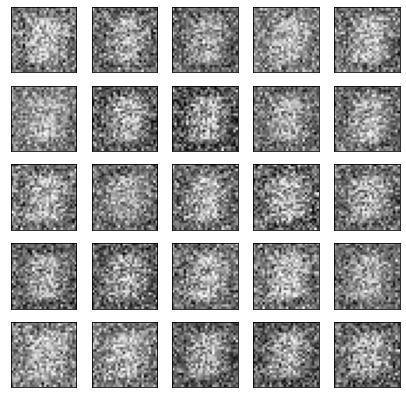

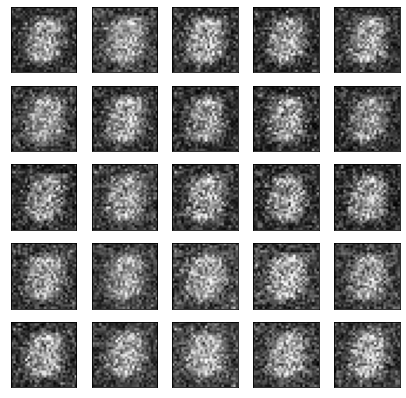

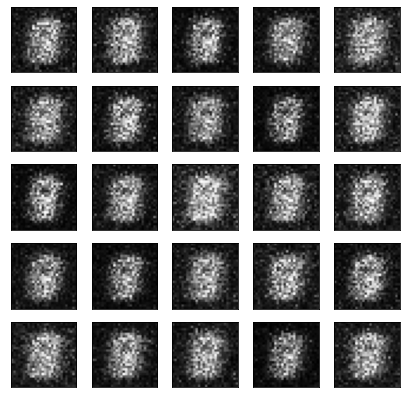

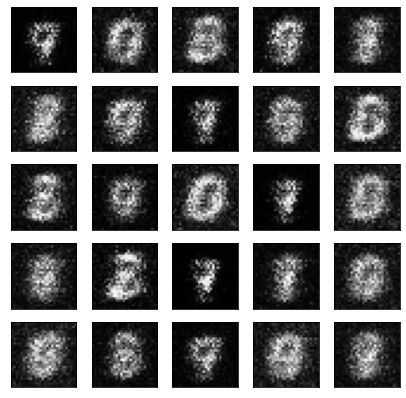

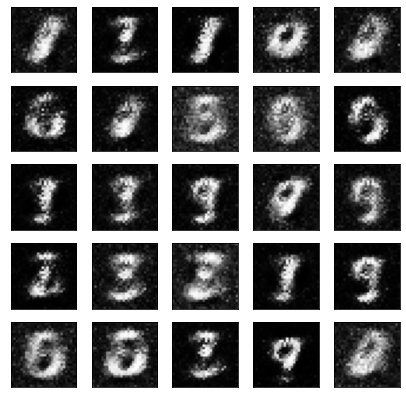

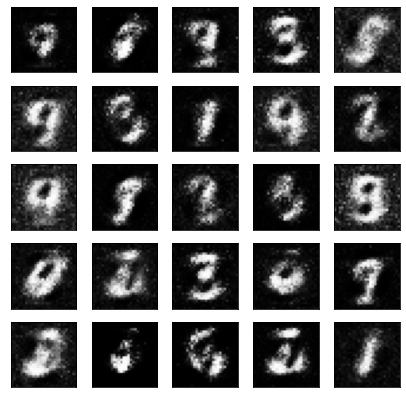

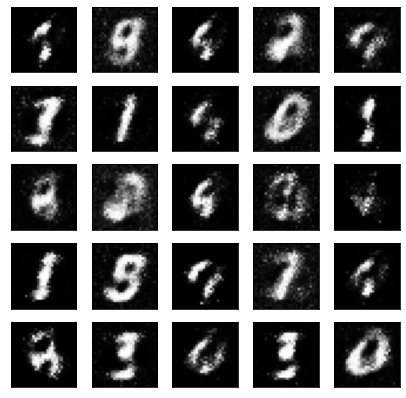

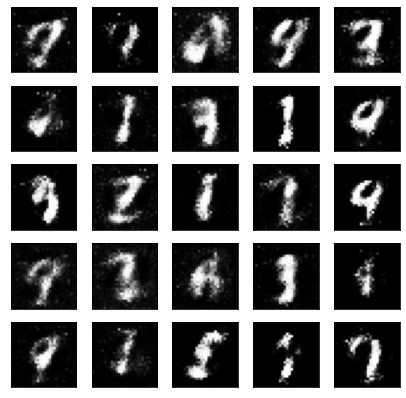

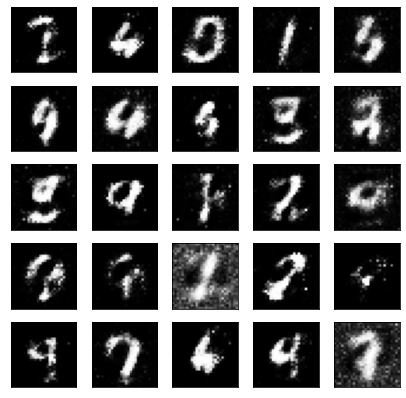

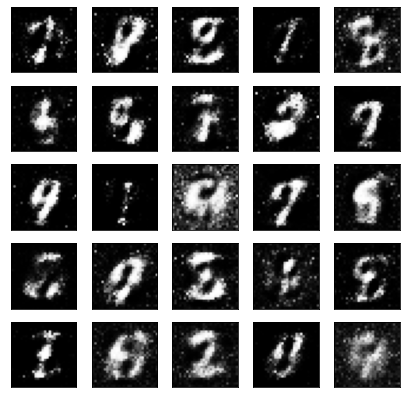

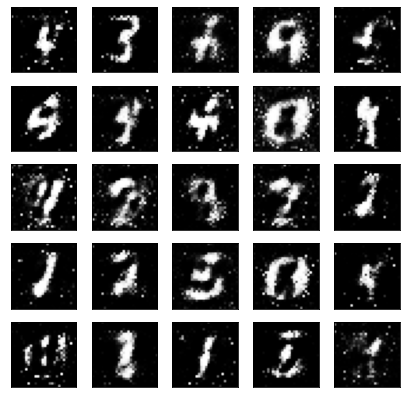

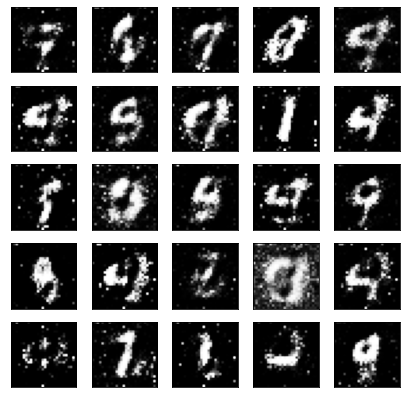

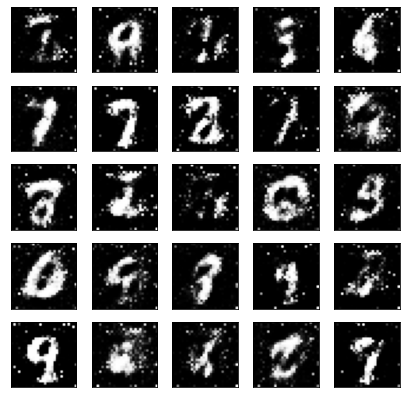

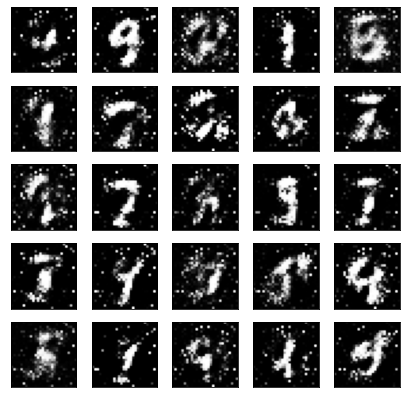

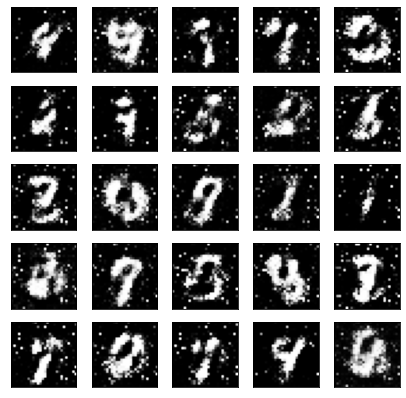

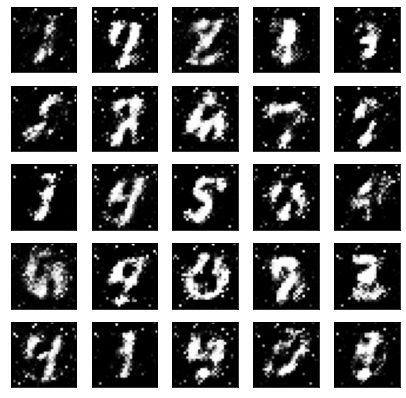

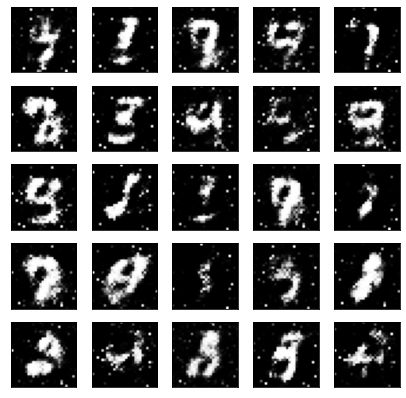

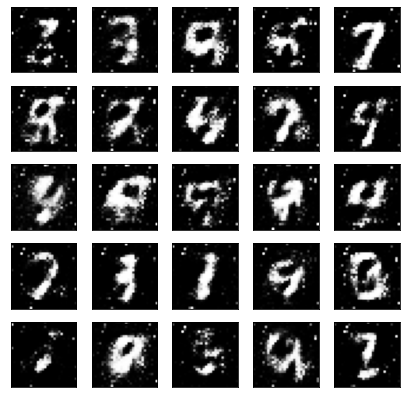

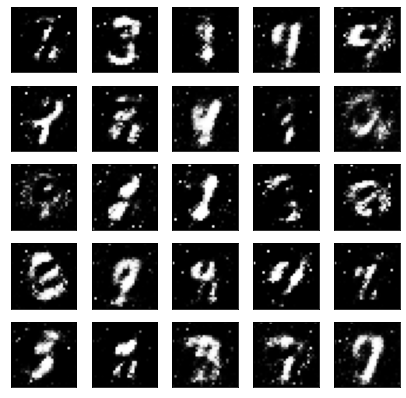

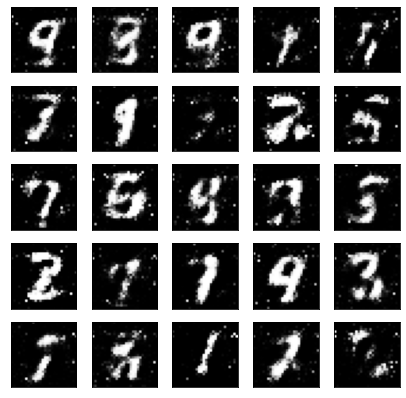

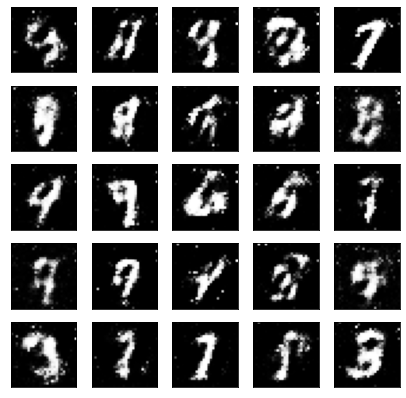

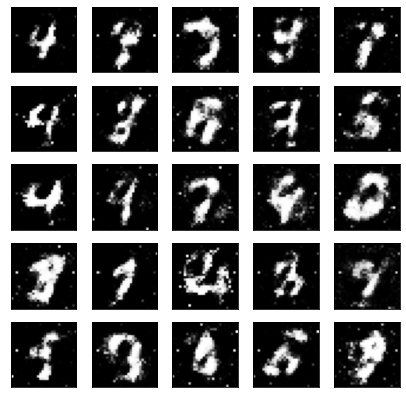

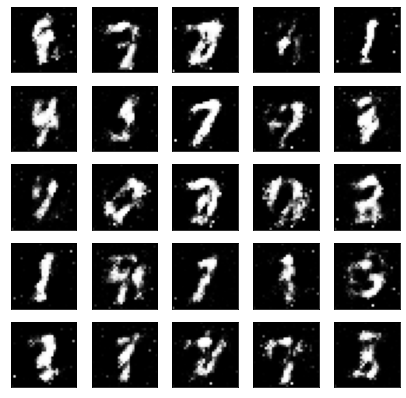

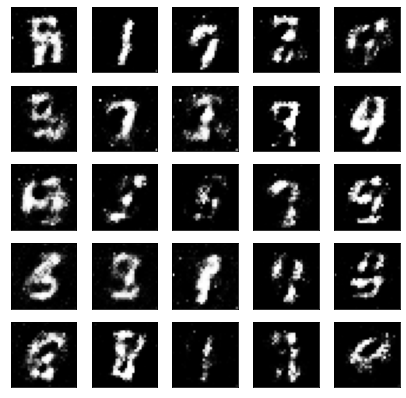

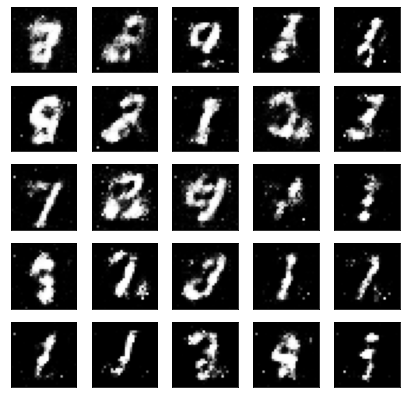

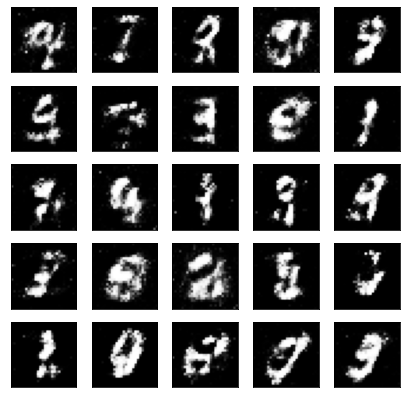

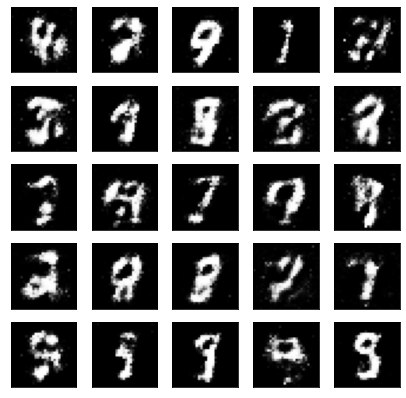

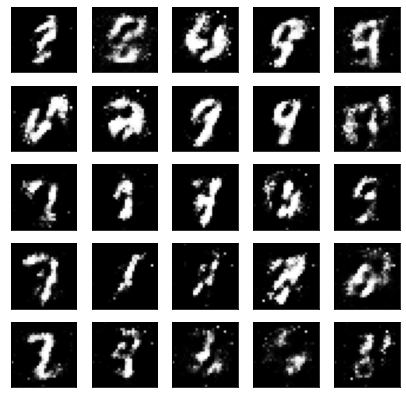

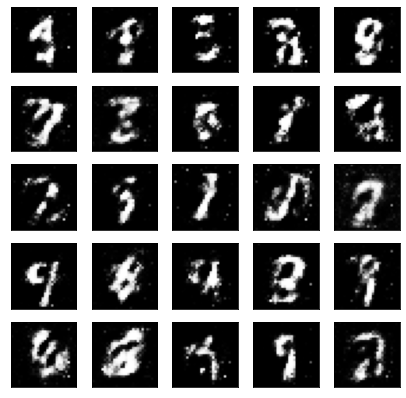

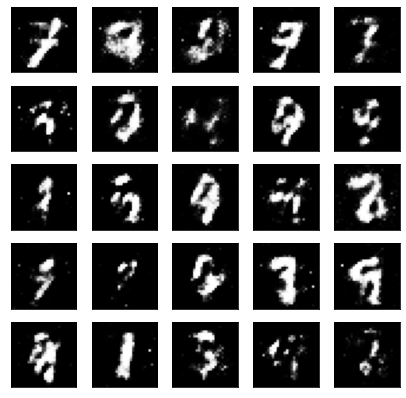

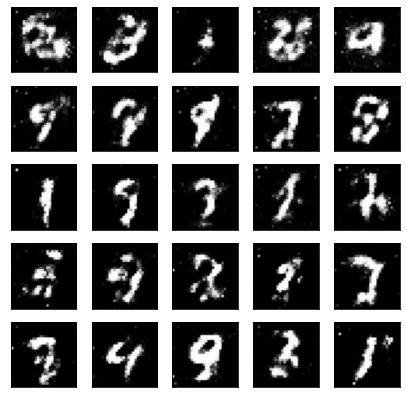

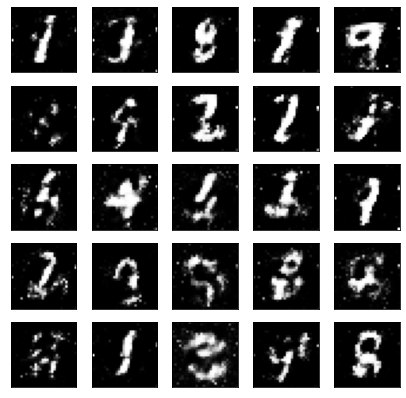

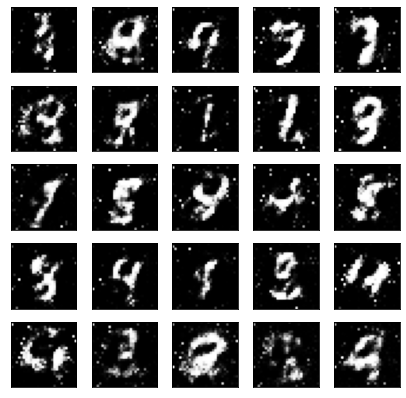

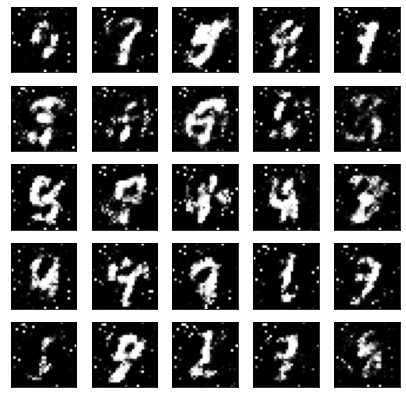

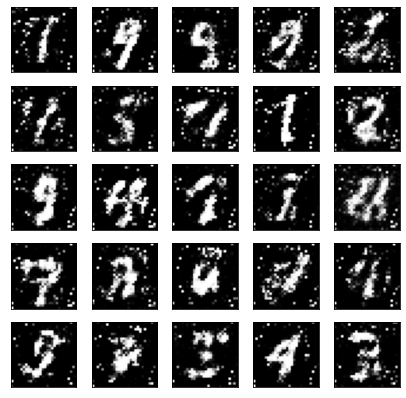

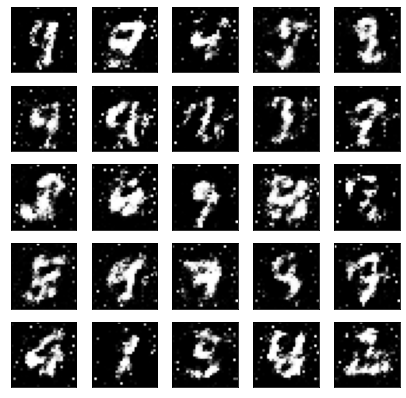

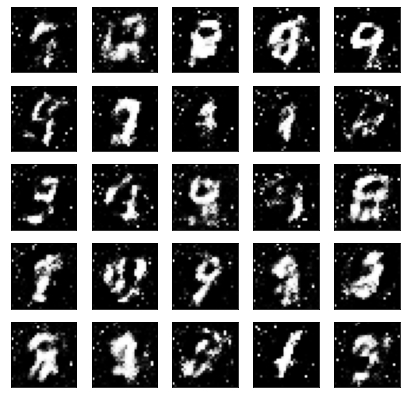

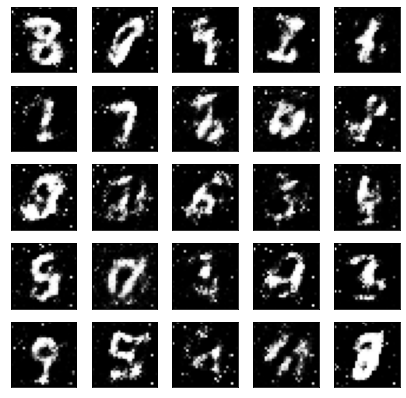

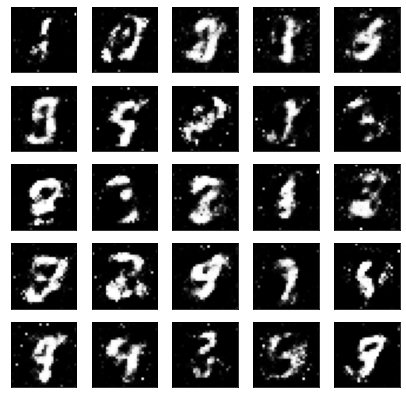

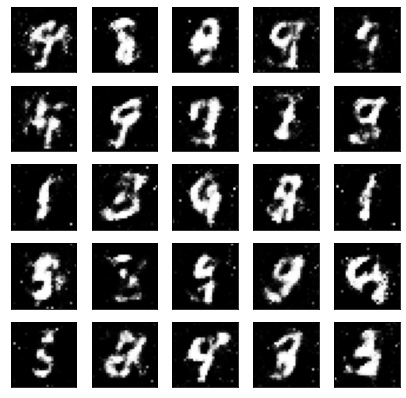

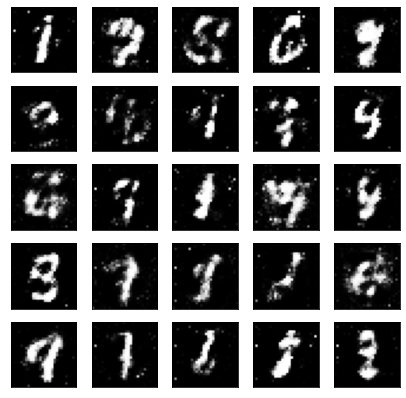

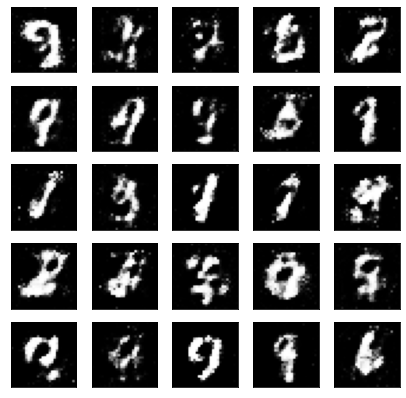

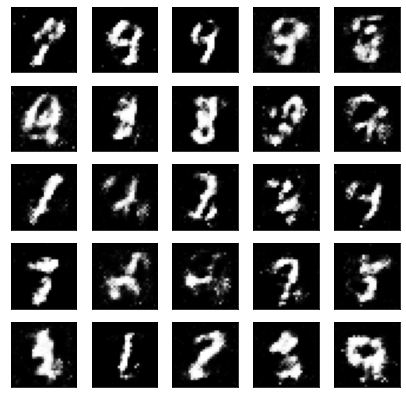

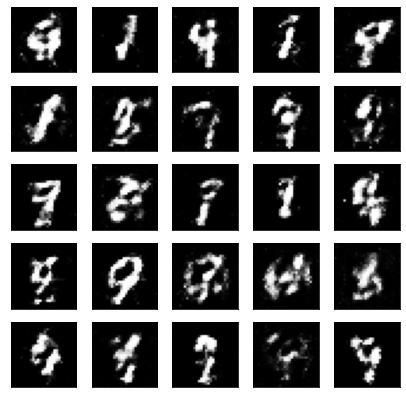

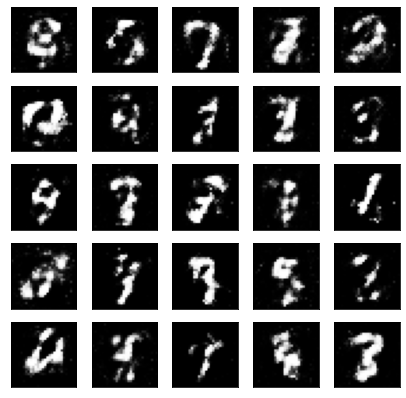

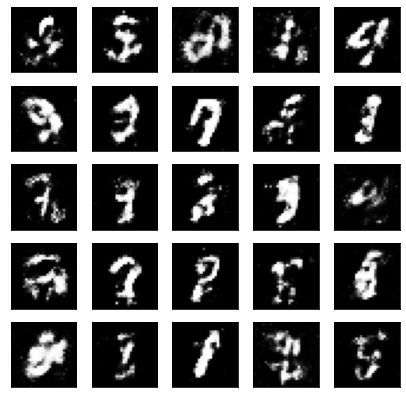

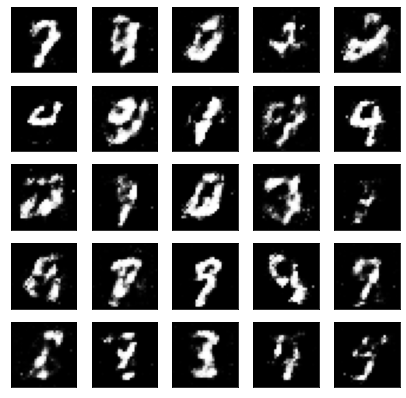

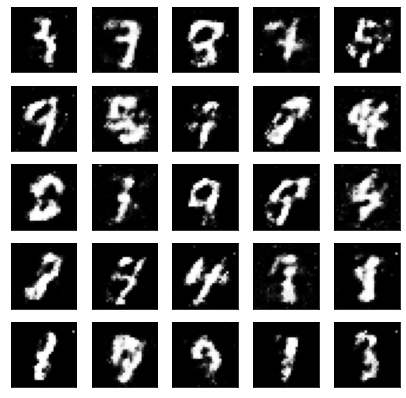

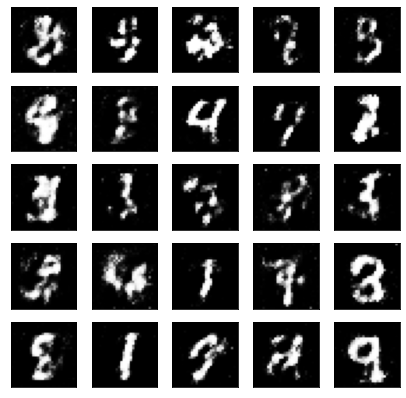

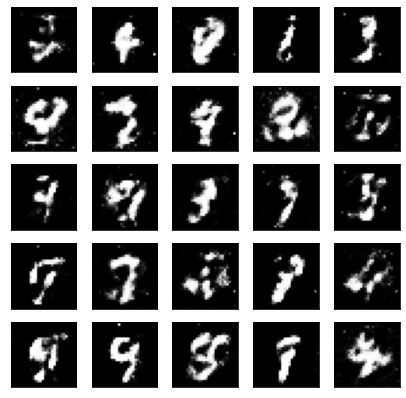

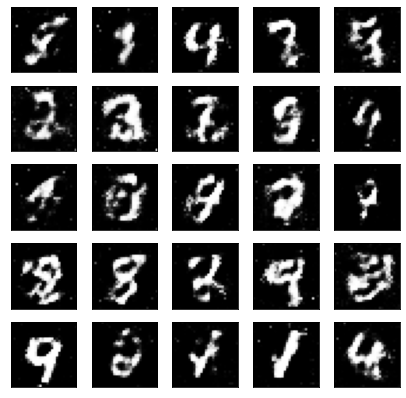

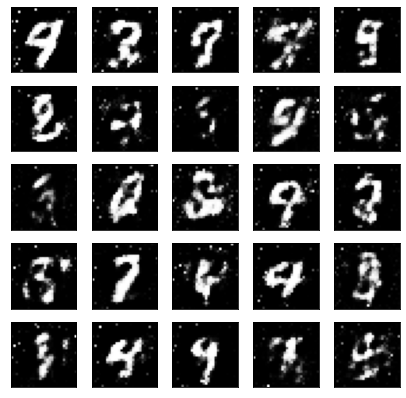

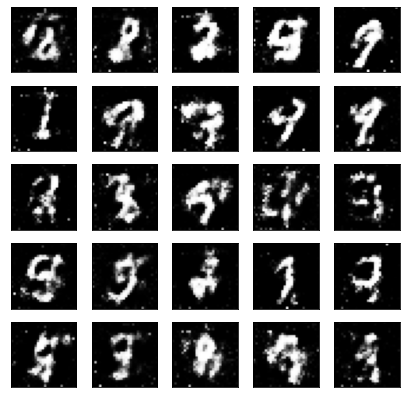

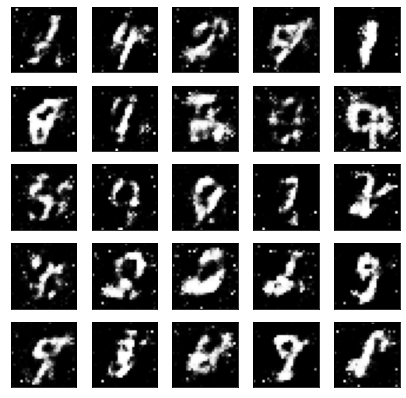

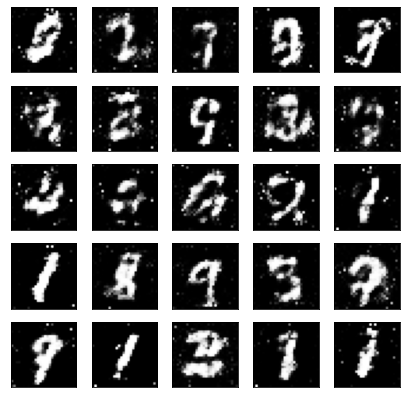

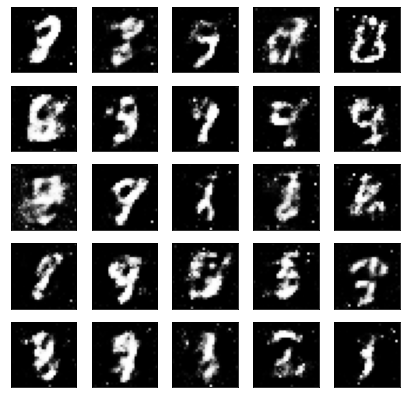

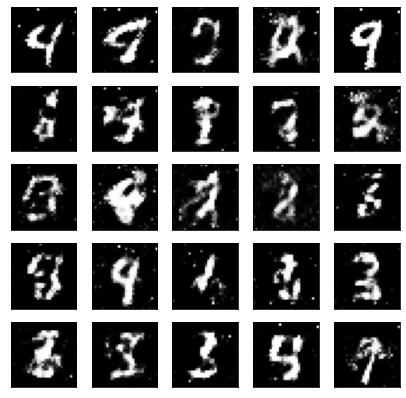

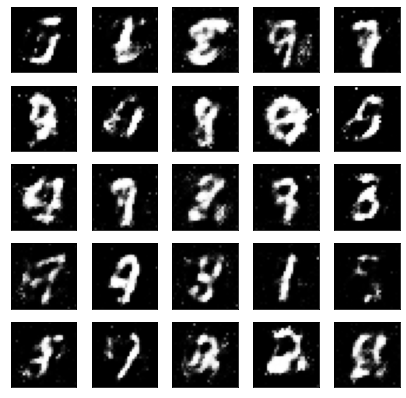

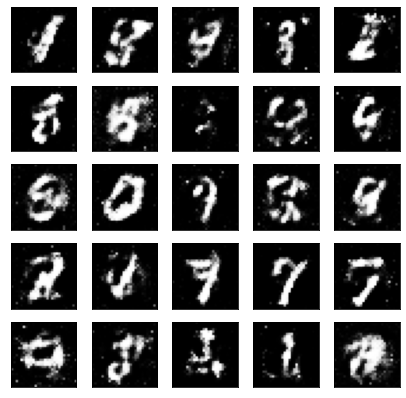

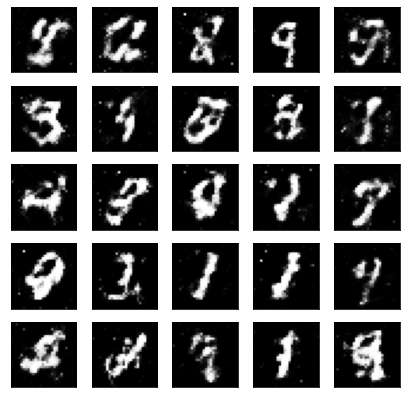

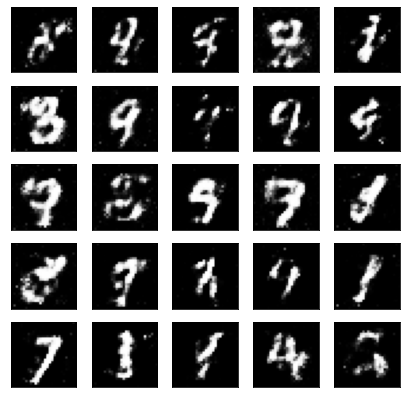

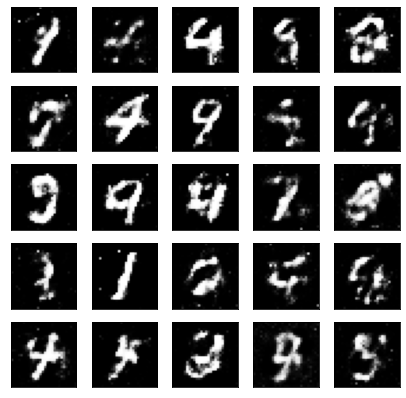

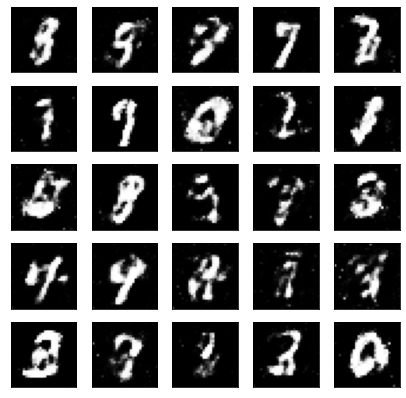

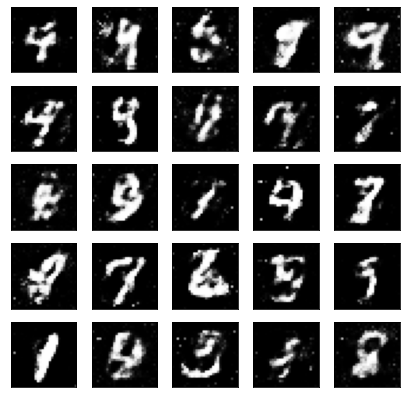

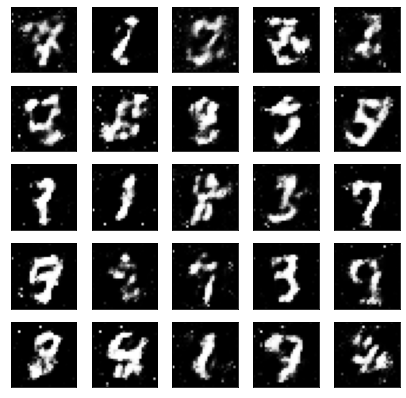

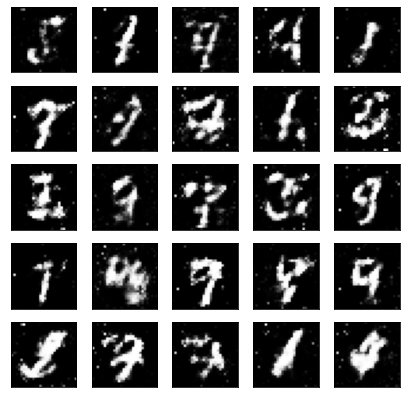

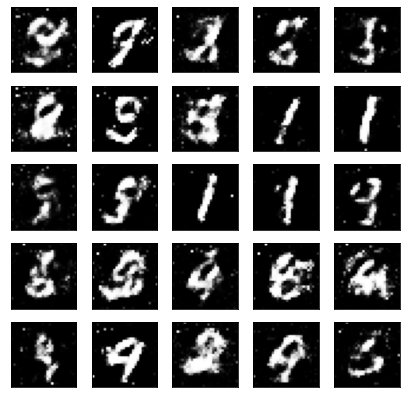

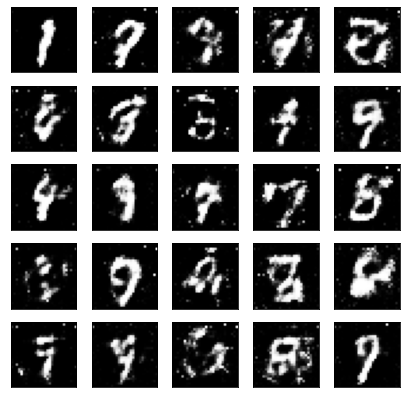

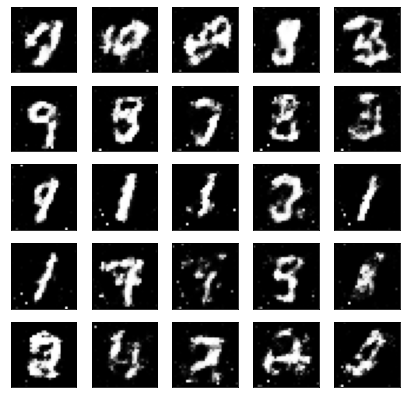

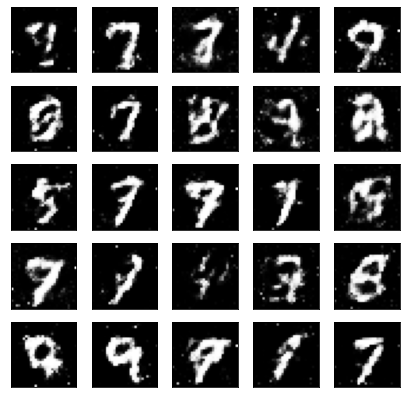

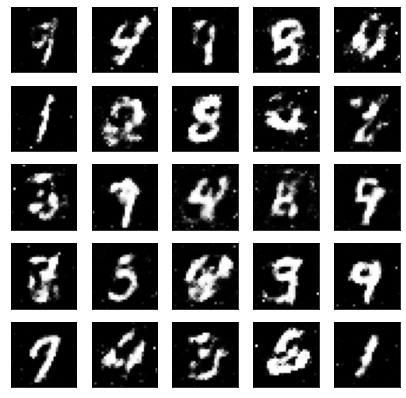

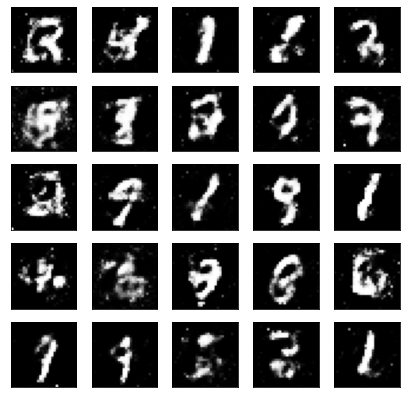

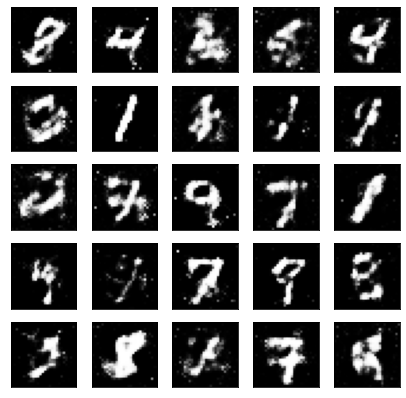

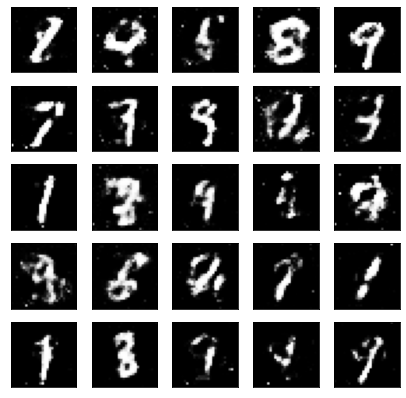

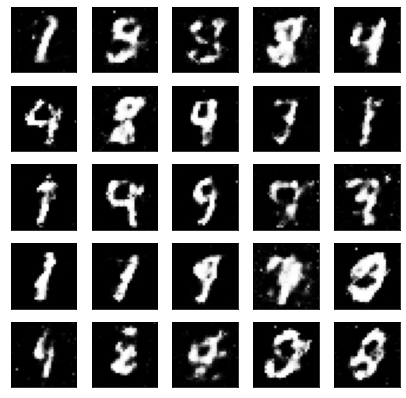

In [ ]:

    # declare the generator and discriminator networks    
    G_net = Generator(G_input_dim, G_output_dim).to(device)
    D_net = Discriminator(D_input_dim, D_output_dim).to(device)

    # Binary Cross Entropy Loss function
    criterion = nn.BCELoss().to(device)

    # Initialise the Optimizers
    G_optimizer = torch.optim.Adam(G_net.parameters(), lr=learning_rate)
    D_optimizer = torch.optim.Adam(D_net.parameters(), lr=learning_rate)

    # tracking variables
    train_hist = {}
    train_hist['D_losses'] = []
    train_hist['G_losses'] = []
    train_hist['per_epoch_ptimes'] = []
    train_hist['total_ptime'] = []

    start_time = time.time()
    # training loop
    for epoch in range(epochs):
        G_net.train()
        D_net.train()
        Loss_G = []
        Loss_D = []
        epoch_start_time = time.time()
        for (image, _) in tqdm(train_loader):
            image = image.to(device)
            b_size = len(image)
            # creat real and fake labels
            real_label = torch.ones(b_size, 1).to(device)
            fake_label = torch.zeros(b_size, 1).to(device)

            # generate fake images 
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))
            data_real = image.view(b_size, D_input_dim)

            # --------train the discriminator network----------
            # compute the loss for real and fake images
            output_real = D_net(data_real)
            output_fake = D_net(data_fake)
            loss_real = criterion(output_real, real_label)
            loss_fake = criterion(output_fake, fake_label)
            loss_d = loss_real + loss_fake

            # back propagation
            D_optimizer.zero_grad()
            loss_d.backward()
            D_optimizer.step()

            # -------- train the generator network-----------
            data_fake = G_net(create_noise(b_size, G_input_dim).to(device))

            # compute the loss for generator network
            output_fake = D_net(data_fake)
            loss_g = criterion(output_fake, real_label)

            ## back propagation
            G_optimizer.zero_grad()
            loss_g.backward()
            G_optimizer.step()

            ## store the loss of each iter
            Loss_D.append(loss_d.item())
            Loss_G.append(loss_g.item())

        epoch_loss_g = np.mean(Loss_G)  # mean generator loss for the epoch
        epoch_loss_d = np.mean(Loss_D)  # mean discriminator loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("Epoch %d of %d with %.2f s" % (epoch + 1, epochs, per_epoch_ptime))
        print("Generator loss: %.8f, Discriminator loss: %.8f" % (epoch_loss_g, epoch_loss_d))

        path = image_save_dir + '/MNIST_GAN_' + str(epoch + 1) + '.png'
        show_result(G_net, create_noise(25, 100).to(device), (epoch + 1), save=True, path=path)

        # record the loss for every epoch
        train_hist['G_losses'].append(epoch_loss_g)
        train_hist['D_losses'].append(epoch_loss_d)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (
        np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))
    print("Training finish!... save training results")
    with open(save_dir + '/train_hist.pkl', 'wb') as f:
        pickle.dump(train_hist, f)
    show_train_hist(train_hist, save=True, path=save_dir + '/MNIST_GAN_train_hist.png')

# 2. Generative Adversarial Networks with PyTorch

## 1.

In [ ]:

class Generator(nn.Module):
    """Image generator
    
    Takes a noise vector as input and syntheses a single channel image accordingly
    """

    def __init__(self, input_dims, output_dims):
        """Init function
        
        Declare the network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of input noise vector
            output_dims {int} -- Dimension of the output vector (flatten image)
        """
        super(Generator, self).__init__()
        ###  TODO: Change the architecture and value as CW2 Guidance required
        self.fc0 = nn.Sequential(
            nn.Linear(input_dims, 100), 
            nn.LeakyReLU(0.2))
        
        self.fc1 = nn.Sequential(
            nn.Linear(100, 256), 
            nn.LeakyReLU(0.2))
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 512), 
            nn.LeakyReLU(0.2))
        
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1024), 
            nn.LeakyReLU(0.2))  
        
        # output hidden layer
        self.fc4 = nn.Sequential(
            nn.Linear(1024, output_dims), 
            nn.Tanh())

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of noise vectors in shape (<batch_size>x<input_dims>)
        
        Returns:
            Tensor -- a batch of flatten image in shape (<batch_size>x<output_dims>)
        """
        ###  TODO: modify to be consistent with the network structure
        x = self.fc0(x)
        x = self.fc1(x)
        return x


class Discriminator(nn.Module):
    """Image discriminator
    
    Takes a image as input and predict if it is real from the dataset or fake synthesised by the generator
    """

    def __init__(self, input_dims, output_dims=1):
        """Init function
        
        Declare the discriminator network structure as indicated in CW2 Guidance
        
        Arguments:
            input_dims {int} -- Dimension of the flatten input images
        
        Keyword Arguments:
            output_dims {int} -- Predicted probability (default: {1})
        """
        super(Discriminator, self).__init__()

        ###  TODO: Change the architecture and value as CW2 Guidance required
        
        self.fc0 = nn.Sequential(
            nn.Linear(input_dims, 784),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """Forward function
        
        Arguments:
            x {Tensor} -- a batch of 2D image in shape (<batch_size>xHxW)
        
        Returns:
            Tensor -- predicted probabilities (<batch_size>)
        """
        ###  TODO: modify to be consistent with the network structure

        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)

        return x

